## 04 中文分词与词元化

首先，我们读取从 `03 Data Augmentation.ipynb` 中保存的增强数据集，并将其拆分为训练集、验证集和测试集。


In [11]:
import pandas as pd

# 读取数据
df = pd.read_csv('data/weibo_augmented.csv', encoding='utf-8-sig')

df = df[["text", "sentiment_polarity"]]
print(f"数据: {len(df)} 行")
df.head()

数据: 391818 行


,text,sentiment_polarity
0,空心菜是世界上最好吃的青菜,1
1,下雪了？好美的雪啊,1
2,哈哈哈娱乐圈文必须有的环节之上综艺打电话环节，必给男主打电话,1
3,亚森发热 发热,0
4,人随春好，春与人宜。,1


### 标签映射

可以看到，数据集使用 `[-1, 0, 1]` 表示情感极性。

后续训练模型时会发现，反向传播时使用的损失函数（`NLLLoss` 或 `CrossEntropyLoss`）要求样本的标签为 `0 ~num_classes-1` 之间的整数，因此需要将情感标签从原始的 `[-1, 0, 1]` 映射到 `[0, 1, 2]`。

这里使用函数 `remap_labels` 来实现标签的映射。

In [12]:
import os
from pandas import DataFrame

def remap_labels(data: DataFrame, label_mapping={-1:0, 0:1, 1:2}):  #@save
    if 2 in data["label"].values:
        return data
    remapped_data = []
    for tokens, old_label in data.values:
        new_label = label_mapping.get(old_label, old_label)
        remapped_data.append((tokens, new_label))
    return DataFrame(remapped_data, columns=["text", "label"])

df = df.rename(columns={"sentiment_polarity": "label"})
df = remap_labels(df)
print(df['label'].value_counts())

label
2    167778
0    124334
1     99706
Name: count, dtype: int64


### 划分数据集
在机器学习任务中，通常需要将数据集划分为训练集、验证集和测试集，以便模型能够在不同的数据上进行训练和评估。

训练集用于模型的训练，验证集用于调参和选择最佳模型，测试集用于最终评估模型的性能。

`sklearn.model_selection` 模块提供了方便的函数 `train_test_split`，可以轻松地将数据集划分为不同的子集。

In [13]:
from sklearn.model_selection import train_test_split

X = df["text"]
y = df["label"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

len(X_train), len(X_val), len(X_test)

(274272, 58773, 58773)

划分数据集结束后，先将每一类的数据集合并为一个 DataFrame，然后保存到本地，方便后续的模型读取处理。

In [14]:
train_raw = DataFrame({"text": X_train, "label": y_train})
val_raw = DataFrame({"text": X_val, "label": y_val})
test_raw = DataFrame({"text": X_test, "label": y_test})

def save_data(data: DataFrame, file_path: str, sep: str = ''):  #@save
    if os.path.exists(file_path):
        print(f"{file_path} 已存在，跳过保存。")
        return
    with open(file_path, 'w', encoding='utf-8') as f:
        for X, y in data.values:
            if not sep:
                f.write(f"{X}:{y}\n")
            else:
                f.write(f"{sep.join(map(str, X))}:{y}\n")
    print(f"已保存到 {file_path}。")

save_data(train_raw, 'data/train_raw.txt')
save_data(val_raw, 'data/val_raw.txt')
save_data(test_raw, 'data/test_raw.txt')

data/train_raw.txt 已存在，跳过保存。
data/val_raw.txt 已存在，跳过保存。
data/test_raw.txt 已存在，跳过保存。


接下来，我们要考虑文本数据的分词与词元化处理。


分词（Word Segmentation）是中文自然语言处理中的基础任务，旨在将连续的汉字序列切分成有意义的词语单元。与英文等语言不同，中文文本中词语之间没有明确的空格分隔符，这使得分词成为中文 NLP 任务中的一个关键步骤。

词元化（Tokenization）是将文本转换为模型可处理的数值形式的过程。对于基于词袋模型（Bag-of-Words）或词嵌入（Word Embeddings）的模型，词元化通常涉及将分词后的词语映射到唯一的整数索引，形成词汇表（Vocabulary）。

下面我们将逐步完成分词、构建词汇表以及词元化的过程。


### 分词（Word Segmentation）

我们使用 LTP 作为分词工具。LTP（Language Technology Platform，语言技术平台）是哈尔滨工业大学社会计算与信息检索研究中心（HIT-SCIR）历时多年研发的一整套高效、高精度的中文自然语言处理开源基础技术平台。相较于常用的分词工具如 Jieba，LTP 在分词方面各方面的表现均较为优秀，适合用于对文本进行高质量的分词处理。

In [ ]:
from pandas import DataFrame

def segment_data(X, y, file_path='', batch_size=500):  #@save
    """
    分批处理数据以避免内存不足问题
    batch_size: 每批处理的数据量，默认1000条
    """
    if os.path.exists(file_path):
        print(f"文件 {file_path} 已存在，直接读取。")
        return load_data(file_path, sep='<sp>', is_segmented=True)
    if not isinstance(X, list):
        X = X.tolist()
    if not isinstance(y, list):
        y = y.tolist()
    
    from ltp import LTP
    ltp = LTP()

    segmented_data = []
    
    print(f"开始处理 {len(X)} 条数据，批大小: {batch_size}")
    
    if len(file_path) > 0:
        # 打开文件准备写入
        with open(file_path, 'w', encoding='utf-8') as f:
            # 分批处理
            for i in range(0, len(X), batch_size):
                batch_end = min(i + batch_size, len(X))
                batch_X = X[i:batch_end]
                batch_y = y[i:batch_end]
                
                print(f"正在处理第 {i//batch_size + 1} 批，数据范围: {i}-{batch_end-1}")
                
                # 对当前批次进行分词
                segment = ltp.pipeline(batch_X, tasks=['cws'], return_dict=False)[0]
                
                # 写入文件
                for sublist, label in zip(segment, batch_y):
                    segmented_data.append((sublist, label))
                    f.write('<sp>'.join(sublist) + ':' + str(label) + '\n')
                
                print(f"第 {i//batch_size + 1} 批处理完成")
    
    print("所有数据处理完成！")
    return DataFrame(segmented_data, columns=["text", "label"])

def load_data(  #@save
        file_path: str, 
        sep='', 
        is_segmented=False, 
        is_indexed=False) -> DataFrame:
    data = []
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        for line in f:
            X, y = line.rsplit(':', 1)
            if is_segmented:
                X = [token.strip() for token in X.split(sep) if token.strip() != '']
            elif is_indexed:
                X = list(map(int, X.split(sep)))
            y = int(float(y))
            data.append((X, y))
    return DataFrame(data, columns=["text", "label"])


# 分批处理数据，使用较小的批大小以避免内存问题
print("开始处理训练集...")
train_seg = segment_data(X_train, y_train, 'data/train_segmented.txt', batch_size=500)

print("\n开始处理验证集...")
val_seg = segment_data(X_val, y_val, 'data/val_segmented.txt', batch_size=500)

print("\n开始处理测试集...")
test_seg = segment_data(X_test, y_test, 'data/test_segmented.txt', batch_size=500);

开始处理训练集...
文件 data/train_segmented.txt 已存在，直接读取。

开始处理验证集...
文件 data/val_segmented.txt 已存在，直接读取。

开始处理测试集...
文件 data/test_segmented.txt 已存在，直接读取。


### 构建词汇表（Vocabulary）

仅使用训练集的数据构建词表 `vocab`：

事先统计训练集中所有词元的词频，用于确认构建词表 `vocab` 的最小词频 `min_freq` 参数。

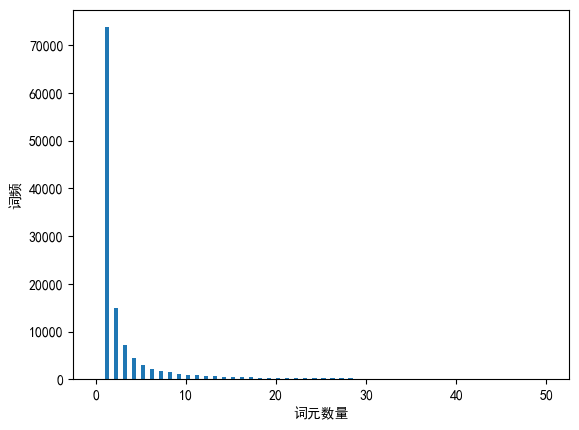

In [16]:
from collections import Counter
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

token_counts = Counter(token for text in train_seg["text"] for token in text)
freqs = list(token_counts.values())
plt.hist(freqs, bins=100, range=(0,50))
plt.xlabel('词元数量')
plt.ylabel('词频')
plt.show();

查看频率最高的前50个词元：

In [17]:
token_counts.most_common(50)

[('的', 144710),
 ('了', 106081),
 ('，', 94593),
 ('我', 91165),
 ('是', 47330),
 ('不', 44745),
 ('。', 44400),
 ('！', 40256),
 ('一', 36995),
 ('好', 32474),
 ('啊', 31787),
 ('就', 23180),
 ('在', 23117),
 ('都', 22244),
 ('想', 19552),
 ('你', 19024),
 ('有', 17667),
 ('要', 16711),
 ('人', 16406),
 ('吃', 16365),
 ('天', 15714),
 ('到', 15601),
 ('这', 14765),
 ('个', 14703),
 ('也', 14267),
 ('看', 13837),
 ('又', 13481),
 ('能', 13446),
 ('很', 13358),
 ('和', 12564),
 ('没', 12309),
 ('会', 11981),
 ('今天', 11959),
 ('一个', 11397),
 ('真', 11079),
 ('去', 11045),
 ('小', 11015),
 ('上', 10775),
 (',', 10744),
 ('还', 10578),
 ('太', 10577),
 ('自己', 10500),
 ('来', 10051),
 ('着', 8776),
 ('给', 8144),
 ('多', 7966),
 ('得', 7604),
 ('说', 7598),
 ('这个', 7540),
 ('吧', 7375)]

分析：
- 出现标点符号：如 `，`、`。`、`！` 等
    - 对于分句作用的符号，如 `，`、`。`、`、` 等，对于情感表达的作用不大，可以考虑去除。
    - 对于表示情感的符号，如 `！`、`？` 等，可以考虑保留。
- 出现虚词，如 `的`、`了`、`在`
    - 尽管此类词语在语义上作用不大，但：
        - 对传统机器学习来说，可通过权重自动弱化
        - 对深度模型来说，它们的词嵌入会自动学到较弱权重
    - 因此考虑保留此类词语

查看词元计数器中出现的所有标点符号：

In [18]:
import unicodedata

punct_tokens = [
    (t, freq) for t, freq in token_counts.items() 
    if all(unicodedata.category(ch).startswith('P') 
           for ch in t)]

punct_tokens

[('！', 40256),
 ('，', 94593),
 (',', 10744),
 ('?', 2072),
 ('。', 44400),
 ('？', 7318),
 ('（', 4378),
 ('）', 3270),
 ('：', 5382),
 ('_', 310),
 ('!', 401),
 ('(', 3017),
 (')', 2995),
 ('《', 43),
 ('》', 43),
 (':', 527),
 ('"', 390),
 ('【', 478),
 ('】', 460),
 ('；', 184),
 ('、', 468),
 (';', 20),
 ('%', 5),
 ('...', 47),
 ('..', 2),
 ('.', 61),
 ('-', 42),
 ('“', 39),
 ('”', 30),
 ('____________', 1),
 ('#', 81),
 ('[', 6),
 (']', 6),
 ('__________', 1),
 ('___', 6),
 ('*', 3),
 ('_____', 2),
 ('____', 4),
 ('###', 3),
 ('@', 1),
 ('##', 3),
 ('¶', 4),
 ('（）', 1),
 ('」', 1),
 ('__', 5),
 ('______', 1),
 ('}', 1),
 ('_______', 1),
 ('________', 1),
 ('\\', 1),
 ("'", 1),
 ('§', 2)]

对标点符号的进一步分类与分析：
- 表示情感的符号：如 `！`、`？` 等，保留

- 分句符号：如 `，`、`。`、`；` 等，去除

- 结构性符号：如 `（`、`）`、`【`、`】` 等，去除

- 异常符号（人工添加线）：如 `_`、`__` 等，去除

In [21]:
def clean_punct(data: DataFrame):
    """
    清理数据集中所有句子中的标点符号
    保留表示情感的符号，去除其他标点符号
    """
    remove_punct = {'，', ',', '。', '；', ';',  '：', ';',
                     '"', '“', '”', '（', '）', '(', ')',  '【', '】', '[', ']',  '《', '》', 
                     '#', '_'}
    cleaned_data = []
    
    removed_index = []
    # 直接操作数据，避免重复创建DataFrame
    for index, tokens, label in data.itertuples():
        cleaned_sentence = [token for token in tokens if token not in remove_punct]
        if len(''.join(cleaned_sentence)) <= 3:
            removed_index.append(index)
        else:
            cleaned_data.append([cleaned_sentence, label])
    
    # 一次性创建DataFrame
    return pd.DataFrame(cleaned_data, columns=["text", "label"]), removed_index


train_seg, train_removed = clean_punct(train_seg)
val_seg, val_removed = clean_punct(val_seg)
test_seg, test_removed = clean_punct(test_seg)

len(train_seg), len(val_seg), len(test_seg)

(273045, 58466, 58491)

上面的函数记录并返回了被删除的样本的索引，根据索引便可以删除原始数据集中对应的样本，保持了后续所有模型的输入样本的一致性。

In [22]:
def remove_data_by_index(data: DataFrame, indices: list):
    """根据索引列表删除DataFrame中的对应行"""
    return data.drop(index=indices).reset_index(drop=True)

train_raw = remove_data_by_index(train_raw, train_removed)
val_raw = remove_data_by_index(val_raw, val_removed)
test_raw = remove_data_by_index(test_raw, test_removed)

print(len(train_raw), len(val_raw), len(test_raw))
print(len(train_seg), len(val_seg), len(test_seg))

274272 58773 58773
273045 58466 58491


构建词表参数 `min_freq` 的设置分析：统计覆盖率

In [24]:
from collections import Counter

token_counts = Counter(token for sentence in train_seg["text"] for token in sentence)
total_tokens = sum(token_counts.values())

for mf in [1, 2, 3, 5, 10]:
    kept_tokens = sum(count for count in token_counts.values() if count >= mf)
    print(f"min_freq: {mf}\tcoverage: {kept_tokens / total_tokens}")

min_freq: 1	coverage: 1.0
min_freq: 2	coverage: 0.975907699306043
min_freq: 3	coverage: 0.966176266050107
min_freq: 5	coverage: 0.9534520308999841
min_freq: 10	coverage: 0.9332263189845745


一般来说，当覆盖率 `coverage` 不小于 95% 时，过滤效果比较合理。

因此，构建词汇表时，我们设置最小词频 `min_freq=3`，即词频小于3的词元将被视为 `<UNK>` 词元，最终可达到约96.6%的覆盖率。

In [26]:
from collections import defaultdict

class Vocab:
    def __init__(self, tokens=None) -> None:
        self.idx_to_token = list()
        self.token_to_idx = dict()

        if tokens is not None:
            if "<unk>" not in tokens:
                tokens = tokens + ["<unk"]
            for token in tokens:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1
            self.unk = self.token_to_idx["<unk>"]

    @classmethod
    def build(cls, text, min_freq=1, reserved_tokens=None):
        token_freqs = defaultdict(int)
        for sentence in text:
            for token in sentence:
                token_freqs[token] += 1
        
        uniq_tokens = ["<unk>"] + (reserved_tokens if reserved_tokens else [])
        uniq_tokens += [token for token, freq in token_freqs.items() 
                        if freq >= min_freq and token != "<unk>"]
        return cls(uniq_tokens)

    def __len__(self) -> int:
        return len(self.idx_to_token)
    
    def __getitem__(self, token):
        """查找输入词元对应的索引值，若不存在，则返回<unk>的索引值（0）"""
        return self.token_to_idx.get(token, self.unk)
    
    def convert_tokens_to_ids(self, tokens):
        """查找一系列输入词元的索引值"""
        return [self[token] for token in tokens]
    
    def convert_ids_to_tokens(self, indices):
        """查找一系列输入索引值对应的词元"""
        return [self.idx_to_token[index] for index in indices]

def save_vocab(vocab: Vocab, file_path: str):
    with open(file_path, 'w', encoding='utf-8-sig') as f:
        f.write('\n'.join(vocab.idx_to_token))

def read_vocab(file_path: str) -> Vocab:
    with open(file_path, 'r', encoding='utf-8-sig') as f:
        tokens = f.read().split('\n')
    return Vocab(tokens)

vocab = Vocab.build(train_seg["text"], min_freq=3)

In [27]:
len(vocab)

35366

### 词元化（Tokenization）

构建好词汇表后，就可以进行词元化处理。具体来说，对数据集中每个句子使用 `vocab.convert_tokens_to_ids` 方法，将句子中的每个词元转换为词元在词汇表中的索引序列，供后续模型训练使用。

In [32]:
train_tok = DataFrame([
    [vocab.convert_tokens_to_ids(text), label]
    for text, label in train_seg.values
], columns=["text", "label"])
val_tok = DataFrame([
    [vocab.convert_tokens_to_ids(text), label]
    for text, label in val_seg.values
], columns=["text", "label"])
test_tok = DataFrame([
    [vocab.convert_tokens_to_ids(text), label]
    for text, label in test_seg.values
], columns=["text", "label"])

In [33]:
for i in range(5):
    print(f"样本 {i+1}：")
    print("原始句子：", train_seg['text'].iloc[i])
    print("词元索引：", train_tok['text'].iloc[i])
    print()

样本 1：
原始句子： ['过年', '进度', '条']
词元索引： [1, 2, 3]

样本 2：
原始句子： ['运动', '使', '我', '快乐']
词元索引： [4, 5, 6, 7]

样本 3：
原始句子： ['哈哈哈', '霸道', '总裁', '爱上', '我']
词元索引： [8, 9, 10, 11, 6]

样本 4：
原始句子： ['私人号', '变成', '工作号', '之后', '每天', '刷', '不', '到', '活人', '朋友圈', '！', '！']
词元索引： [0, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 21]

样本 5：
原始句子： ['失败', '的', '贝果']
词元索引： [22, 23, 24]



将数据集与词汇表保存至本地。

In [35]:
save_data(train_tok, 'data/train_tokenized.txt', sep=',')
save_data(val_tok, 'data/val_tokenized.txt', sep=',')
save_data(test_tok, 'data/test_tokenized.txt', sep=',')

save_vocab(vocab, 'data/vocab.txt')

data/train_tokenized.txt 已存在，跳过保存。
data/val_tokenized.txt 已存在，跳过保存。
data/test_tokenized.txt 已存在，跳过保存。
